In [1]:
##### Step 0: Import Libraries 

In [2]:
import numpy as np
import h5py
import glob
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.layers import *
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.backend as K
from keras.models import load_model

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import MDAnalysis

import sys
sys.path.append('/athena/hwlab/scratch/mar4026/DNN')
from trajectory_tools.tools import *
from nets.densenet161 import *

from vis.utils import utils
from vis.visualization import *

from matplotlib import pyplot as plt
%matplotlib inline

import os

# os.environ["CUDA_VISIBLE_DEVICES"]="2,3"
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#K.tensorflow_backend._get_available_gpus()

ModuleNotFoundError: No module named 'keras'

In [ ]:
## User parameters ####################
dim_diff = 10 # dimension difference, when you convert list to image 1D to 2D. Difference between x and y is 10(no need to change)
num_classes = 3 # Number of classes (User input)
stride=1 # stride of sample input

checkpoint_load = './checkpoints_regularize_lr%s/' # path to the weight to be evaluated
Data_DIR = '/athena/hwlab/scratch/mar4026/DNN/step_2_get_xyz/'

if checkpoint_load[-1]!='/': checkpoint_load=checkpoint_load+'/'
if Data_DIR[-1]!='/': Data_DIR=Data_DIR+'/'

# Input  labels
class1_labels_file = Data_DIR + 'labels_OFS.dat'
class2_labels_file = Data_DIR + 'labels_OcS.dat'
class3_labels_file = Data_DIR + 'labels_IFS.dat'

# Input data -- without data augumentation 
class1_data_files = [ Data_DIR + 'coordinates_OFS.dat' ]
class2_data_files = [ Data_DIR + 'coordinates_OcS.dat' ]
class3_data_files = [ Data_DIR + 'coordinates_IFS.dat' ]

'''
# Input data -- with data augumentation 
class1_data_files = [ Data_DIR+'coordinates_OFS1.dat', Data_DIR+'coordinates_OFS2.dat', Data_DIR+'coordinates_OFS3.dat' ]
class2_data_files = [ Data_DIR+'coordinates_OcS1.dat', Data_DIR+'coordinates_OcS2.dat', Data_DIR+'coordinates_OcS3.dat' ]
class3_data_files = [ Data_DIR+'coordinates_IFS1.dat', Data_DIR+'coordinates_IFS2.dat', Data_DIR+'coordinates_IFS3.dat' ]
## To do data augumentation, multiple data files are loaded, where the same 
## frame in different files belong to the same protein structure but different scrambles
'''

if type(class1_data_files)!=list: class1_data_files=[class1_data_files]
if type(class2_data_files)!=list: class2_data_files=[class2_data_files]
if type(class3_data_files)!=list: class3_data_files=[class3_data_files]

######################################


In [ ]:
# Import labels
h5f = h5py.File(class1_labels_file,'r')
CLASS1_label = h5f['labels'][::1]+0
h5f.close()

h5f = h5py.File(class2_labels_file,'r')
CLASS2_label = h5f['labels'][::1]+0
h5f.close()

h5f = h5py.File(class3_labels_file,'r')
CLASS3_label = h5f['labels'][::1]+0
h5f.close()

# Obtain total number of sample (total_id)
labels = np.concatenate((CLASS1_label, CLASS2_label, CLASS3_label))
total_id =  np.arange(len(labels))

# Split into training, validation and test set 
# split of test from train 
X_train_id, X_test_id, Y_train, Y_test = train_test_split(total_id, labels, test_size=0.20, random_state=42) 
# random_state makes sure you keep the same samples in each so that next time not in valid
# split of valid from train 
X_train_id, X_valid_id, Y_train, Y_valid = train_test_split(X_train_id, Y_train, test_size=0.30, random_state=66)

# Convert each element in Y to vector that has length of # of classes 
# i.e. Y used to be 0,1,2, when y=0 converts to vector [1,0,0], y=1 converts to vector [0,1,0], when y=2 converts to vector [0,0,1]
Y_train_temp = np_utils.to_categorical(Y_train, num_classes)[::stride,:]
Y_valid_temp = np_utils.to_categorical(Y_valid, num_classes)[::stride,:]
Y_test_temp = np_utils.to_categorical(Y_test, num_classes)[::stride,:]


In [3]:
# Import data:
## Apply the same subset assignment to each copy of the dataset
## so that the different scrambles that belongs to the same protein
## will always be assigned to the same subset
dataset_imported = 0
data_augument_fold = len(class1_data_files)
for i in range(data_augument_fold):
    h5f = h5py.File(class1_data_files[i],'r')
    CLASS1_DATA = h5f['dataset'][::1]+0
    h5f.close()
    h5f = h5py.File(class2_data_files[i],'r')
    CLASS2_DATA = h5f['dataset'][::1]+0
    h5f.close()
    h5f = h5py.File(class3_data_files[i],'r')
    CLASS3_DATA = h5f['dataset'][::1]+0
    h5f.close()
    data_set_temp = np.concatenate((CLASS1_DATA, CLASS2_DATA, CLASS3_DATA), axis=0)
    del CLASS1_DATA, CLASS2_DATA, CLASS3_DATA #clean memory
    if dataset_imported == 0:
        dataset_shape = np.array(data_set_temp.shape)
        dataset_shape[0] = 0
        total_train = np.zeros(dataset_shape)
        total_valid = np.zeros(dataset_shape)
        total_test = np.zeros(dataset_shape)
        dataset_imported = 1
    data_train = data_set_temp[X_train_id,:,:][::stride,:,:]
    data_valid = data_set_temp[X_valid_id,:,:][::stride,:,:]
    data_test = data_set_temp[X_test_id,:,:][::stride,:,:]
    del data_set_temp #clean memory
    total_train = np.concatenate((total_train,data_train), axis=0)
    total_valid = np.concatenate((total_valid,data_valid), axis=0)
    total_test = np.concatenate((total_test,data_test), axis=0)
    del data_train, data_valid, data_test #clean memory

# make replicas of Y
Y_train = Y_train_temp
Y_valid = Y_valid_temp
Y_test = Y_test_temp
for i in range(data_augument_fold-1):
    Y_train = np.concatenate((Y_train,Y_train_temp), axis=0)
    Y_valid = np.concatenate((Y_valid,Y_valid_temp), axis=0)
    Y_test = np.concatenate((Y_test,Y_test_temp), axis=0)

# convert to visual representation
X_train = traj_to_img(total_train, dim_diff=dim_diff)
X_valid = traj_to_img(total_valid, dim_diff=dim_diff)
X_test = traj_to_img(total_test, dim_diff=dim_diff)




NameError: name 'class1_data_files' is not defined

In [21]:
#check data shape
print("X_train:",X_train.shape)
print("X_valid:",X_valid.shape)
print("X_test:",X_test.shape)
print("Y_train:",Y_train.shape)
print("Y_valid:",Y_valid.shape)
print("Y_test:",Y_test.shape)


In [22]:
#clean up
del Y_train_temp, Y_valid_temp, Y_test_temp
del total_train, total_valid, total_test


In [23]:
# data normalization
train_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
train_datagen.fit(X_train) # Either fit with the same sample, or load from the checkpoint folder
#norm_parameters = np.loadtxt(checkpoint_load + "normalization.dat").astype(float)
#train_datagen.mean = np.array([[norm_parameters[0,:]]]) # Either fit with the same sample, or load from the checkpoint folder
#train_datagen.std = np.array([[norm_parameters[1,:]]]) # Either fit with the same sample, or load from the checkpoint folder

X_train = train_datagen.standardize(X_train)
X_valid = train_datagen.standardize(X_valid)
X_test = train_datagen.standardize(X_test)


In [7]:
##### Step 3: Load Model and Weight 

In [25]:
def buildmodel(X_train, Y_train, X_valid, Y_valid, num_classes=num_classes):
    if __name__ == '__main__':
        img_rows, img_cols =  X_train.shape[1], X_train.shape[2] # Resolution of inputs
        channel = 3
        model = densenet161_model(img_rows=img_rows, 
            img_cols=img_cols, color_type=channel, 
            num_classes=num_classes, nb_dense_block=3, 
            growth_rate=48, nb_filter=96, reduction=0.5, 
            dropout_rate=0.0, weight_decay=0.0,learn_rate=0.0001)
        return model

model = buildmodel(X_train, Y_train, X_valid, Y_valid)
model.load_weights(checkpoint_load + 'weights_best_val_loss.hdf5') #load the weight to be evaluated


/athena/hwlab/scratch/mar4026/DNN/nets/densenet161.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (5, 5), name="conv1", use_bias=False, strides=(2, 2))`
  x = Conv2D(nb_filter, (5, 5), subsample=(2, 2), name='conv1', use_bias=False)(x)


In [27]:
# change the output layer to linear for saliency detection
layer_idx = utils.find_layer_idx(model, 'aux_output')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)
layer_idx

440

In [28]:
# Save the model with loaded parameters and a linear output layer
model.save('model_1_MFSD2A_best_loss_decay.h5')

In [29]:
##### Step 4: obtain the samples where the predictions show best confidence

In [30]:
# Find indices where in Y_test that are from class 0,1,2
# only select those in the first copy of data augumentation, so they belong to different proteins
class1_ind = np.where(np.argmax(Y_test[:len(labels)], axis=1)==0)[0]
class2_ind = np.where(np.argmax(Y_test[:len(labels)], axis=1)==1)[0]
class3_ind = np.where(np.argmax(Y_test[:len(labels)], axis=1)==2)[0]

In [32]:
# using the indices found in the previous step,
# select the corresponding test samples (X_test) for each class
# this effectively separates the test dataset into their true class labels

class1_X_test_full = X_test[class1_ind,:,:]
class2_X_test_full = X_test[class2_ind,:,:]
class3_X_test_full = X_test[class3_ind,:,:]

In [33]:
# saves the test set as 3 separate files (1 per class)

#pickle.dump(class1_X_test_full,open('./MFSD2A_OFS_decay.dat', "wb" ))
#pickle.dump(class2_X_test_full,open('./MFSD2A_OcS_decay.dat', "wb" ))
#pickle.dump(class3_X_test_full,open('./MFSD2A_IFS_decay.dat', "wb" ))

In [34]:
# computes accuracy for test set 

scores1 = model.predict(class1_X_test_full, verbose=1)
scores2 = model.predict(class2_X_test_full, verbose=1)
scores3 = model.predict(class3_X_test_full, verbose=1)

1472/1472 [==============================] - 3355s 2s/step


In [35]:
print(np.mean((np.argmax(scores1, axis=1)==0)))
print(np.mean((np.argmax(scores2, axis=1)==1)))
print(np.mean((np.argmax(scores3, axis=1)==2)))

0.938749194068343
0.9966953073364178
0.9952445652173914


In [36]:
# make empty visualization files so that we can use them later on
# this will hold visualization/ saliency data 

vis_sal_class1_test = np.empty(class1_X_test_full.shape[:3])
pickle.dump(vis_sal_class1_test,open('./MFSD2A_OFS_vis_decay.dat', "wb" ))

vis_sal_class2_test = np.empty(class1_X_test_full.shape[:3])
pickle.dump(vis_sal_class1_test,open('./MFSD2A_OcS_vis_decay.dat', "wb" ))

vis_sal_class3_test = np.empty(class1_X_test_full.shape[:3])
pickle.dump(vis_sal_class1_test,open('./MFSD2A_IFS_vis_decay.dat', "wb" ))

In [37]:
# Finds where model's prediction is class 0,1,2 for 1000 samples in test set 

class1_vis_data = class1_X_test_full[(np.argmax(scores1, axis=1)==0)][:1000]
class2_vis_data = class2_X_test_full[(np.argmax(scores2, axis=1)==1)][:1000]
class3_vis_data = class3_X_test_full[(np.argmax(scores3, axis=1)==2)][:1000]

In [38]:
# saves 1000 samples from test set per class (0,1,2)

pickle.dump(class1_vis_data,open('./MFSD2A_OFS_test_score_decay.dat', "wb" ))
pickle.dump(class2_vis_data,open('./MFSD2A_OcS_test_score_decay.dat', "wb" ))
pickle.dump(class3_vis_data,open('./MFSD2A_IFS_test_score_decay.dat', "wb" ))

In [ ]:
##### Go to STEP 4 SENSITIVITY ANALYSIS AND RETURN 

In [ ]:
##### Step 5: Visualization Map Data and Test Data 

In [16]:
vis_file='./MFSD2A_OFS_vis.dat' # visualization/ saliency map data 
data_file='./MFSD2A_OFS_test_score.dat' # data file 
start=0
block=20
index=0
end=start+block

print(start, end)

# Load Model and Test Data 
vis_sal_class1_test = pickle.load( open(vis_file, "rb" ) )
model = load_model('model_1_MFSD2A_best_loss.h5')
class1_test = pickle.load( open(data_file, "rb" ) )
layer_idx = utils.find_layer_idx(model, 'aux_output')
layer_idx

0 20


440

In [17]:
motif_region=[[39,68],[75,101],[110,129],[137,167],[171,202],[233,263],[292,318],[328,353],[358,374],[382,416],[424,450],[465,491]]
motif_name=["TM1","TM2","TM3","TM4","TM5","TM6","TM7","TM8","TM9","TM10","TM11","TM12"]

In [18]:
# Load in residues (specific to system)

df_prot_res_map = pd.read_csv('MFSD2A_TMS.txt', sep='\s+',header=None)
prot_res_map = df_prot_res_map.values
prot_res_map = prot_res_map.flatten()
len(prot_res_map)

5209

In [19]:
vis_file='./MFSD2A_OFS_vis.dat' # Load visualization data 
data_file='./MFSD2A_OFS_test_score.dat' # Load test data 

# vis data assigned to variable 'vis_sal_class1_test'
vis_sal_class1_test = pickle.load( open(vis_file, "rb" ) ) 

# test data assigned to variable 'class1_test'
class1_test = pickle.load( open(data_file, "rb" ) )

# computes mean of the saliency maps: sums all the saliency maps and then divides by 1000 to get average
vis_sal_class1_test_mean = np.sum(vis_sal_class1_test, axis=0)/1000

In [20]:
vis_file='./MFSD2A_OcS_vis.dat'
data_file='./MFSD2A_OcS_test_score.dat'
vis_sal_class2_test = pickle.load( open(vis_file, "rb" ) )
class2_test = pickle.load( open(data_file, "rb" ) )
vis_sal_class2_test_mean = np.sum(vis_sal_class2_test, axis=0)/1000

In [21]:
vis_file='./MFSD2A_IFS_vis.dat'
data_file='./MFSD2A_IFS_test_score.dat'
vis_sal_class3_test = pickle.load( open(vis_file, "rb" ) )
class3_test = pickle.load( open(data_file, "rb" ) )
vis_sal_class3_test_mean = np.sum(vis_sal_class3_test, axis=0)/1000

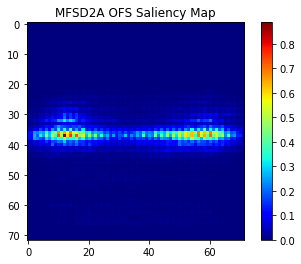

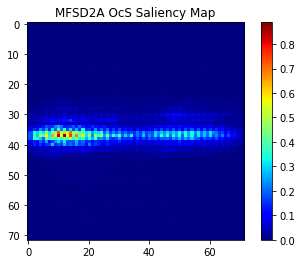

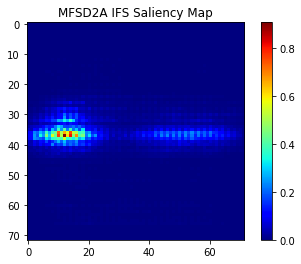

In [22]:
plt.imshow(vis_sal_class1_test_mean, cmap='jet',vmin=0)
plt.colorbar()
plt.title('MFSD2A OFS Saliency Map')
#plt.savefig('../faDNN_chol35_sal.png', dpi=300)
plt.show()

plt.imshow(vis_sal_class2_test_mean, cmap='jet',vmin=0)
plt.colorbar()
plt.title('MFSD2A OcS Saliency Map')
#plt.savefig('../faDNN_chol35_sal.png', dpi=300)
plt.show()

plt.imshow(vis_sal_class3_test_mean, cmap='jet',vmin=0)
plt.colorbar()
plt.title('MFSD2A IFS Saliency Map')
#plt.savefig('../faDNN_chol35_sal.png', dpi=300)
plt.show()

In [17]:
# Tells you shape of picture (x, y)
vis_sal_class1_test_mean.shape

(72, 72)

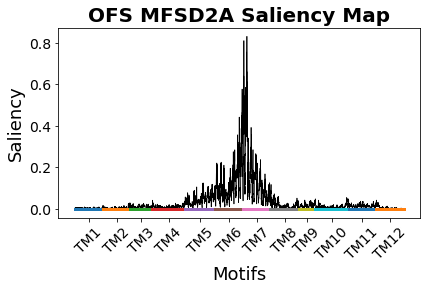

In [9]:
plt.plot(vis_sal_class1_test_mean.flatten(), "k", linewidth=0.7)
xtick_list = []

for i in range(len(motif_name)):
    motif_start_res = motif_region[i][0]
    motif_end_res = motif_region[i][1]
    motif_start_atom = np.where(prot_res_map==motif_start_res)[0][0]
    motif_end_atom = np.where(prot_res_map<=motif_end_res)[0][-1]
    plt.plot([motif_start_atom, motif_end_atom], [0, 0], linewidth=3)  # Increase the linewidth if needed
    xtick_list.append((motif_start_atom+motif_end_atom)/2)

plt.xticks(xtick_list, motif_name, rotation=45) 
plt.title('OFS MFSD2A Saliency Map', fontsize=20, fontweight='bold')
plt.xlabel('Motifs',fontsize=18)  # Label for x-axis
plt.ylabel('Saliency',fontsize=18)  # Label for y-axis
plt.tight_layout()  # Adjust the layout to fit everything
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
# plt.savefig('mfds2a_saliency_map_transformed.png', dpi=300)  # Uncomment to save the figure
plt.show()

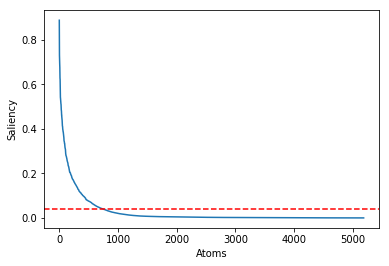

In [9]:
data = sorted(vis_sal_class1_test_mean.flatten(), reverse=True)
plt.plot(data)
plt.axhline(y=0.03796322514838539, color='r', linestyle='--')
plt.xlabel('Atoms')
plt.ylabel('Saliency')
plt.show()

In [10]:
from kneed import KneeLocator

x = range(1, len(data) + 1)

# Find the knee point
knee_locator = KneeLocator(x, data, curve='convex', direction='decreasing', S=10)
knee_point = knee_locator.knee  # This is the x value of the knee point

print(f"The knee point is at x (nFeat) = {knee_point}, and score of: {knee_locator.knee_y}")

The knee point is at x (nFeat) = 764, and score of: 0.03796322514838539


In [24]:
top_atoms_OFS= np.where(vis_sal_class1_test_mean.flatten()>= 0.5)[0]
top_atoms_OFS

residue_numbers = set()

# Loop through the top atoms and add their associated residue numbers to the set.
for atom_number in top_atoms_OFS:
    if 0 <= atom_number < len(prot_res_map):
        residue_number = prot_res_map[atom_number]
        residue_numbers.add(residue_number)

# Convert the set of residue numbers to a sorted list if needed.
residue_numbers_list1 = sorted(list(residue_numbers))

# Now, residue_numbers_list contains the residue numbers associated with the top 80 atoms.
print('OFS with saliency 0.5:',residue_numbers_list1)

OFS with saliency 0.5: [259, 262, 293, 294, 295, 296, 297, 299]


In [11]:
top_atoms_OFS= np.argsort(vis_sal_class1_test_mean.flatten())[-764:]
top_atoms_OFS

residue_numbers = set()

# Loop through the top atoms and add their associated residue numbers to the set.
for atom_number in top_atoms_OFS:
    if 0 <= atom_number < len(prot_res_map):
        residue_number = prot_res_map[atom_number]
        residue_numbers.add(residue_number)

# Convert the set of residue numbers to a sorted list if needed.
residue_numbers_list1 = sorted(list(residue_numbers))

# Now, residue_numbers_list contains the residue numbers associated with the top 80 atoms.
print('OFS:',residue_numbers_list1)

OFS: [180, 182, 189, 190, 191, 192, 193, 194, 195, 198, 199, 200, 202, 233, 234, 235, 238, 239, 240, 242, 243, 244, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 328, 330, 331]


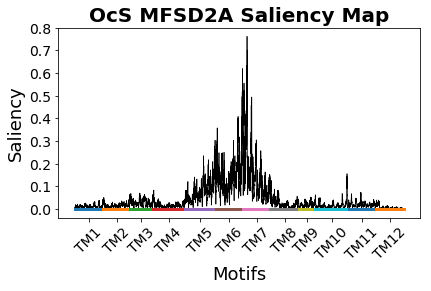

In [11]:
plt.plot(vis_sal_class2_test_mean.flatten(), "k", linewidth=0.7)
xtick_list = []

for i in range(len(motif_name)):
    motif_start_res = motif_region[i][0]
    motif_end_res = motif_region[i][1]
    motif_start_atom = np.where(prot_res_map==motif_start_res)[0][0]
    motif_end_atom = np.where(prot_res_map<=motif_end_res)[0][-1]
    plt.plot([motif_start_atom, motif_end_atom], [0, 0], linewidth=3)  # Increase the linewidth if needed
    xtick_list.append((motif_start_atom+motif_end_atom)/2)

plt.xticks(xtick_list, motif_name, rotation=45) 
plt.title('OcS MFSD2A Saliency Map', fontsize=20, fontweight='bold')
plt.xlabel('Motifs',fontsize=18)  # Label for x-axis
plt.ylabel('Saliency',fontsize=18)  # Label for y-axis
plt.tight_layout()  # Adjust the layout to fit everything
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
# plt.savefig('mfds2a_saliency_map_transformed.png', dpi=300)  # Uncomment to save the figure
plt.show()

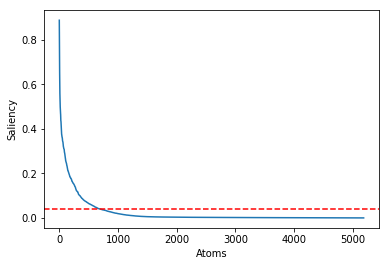

The knee point is at x (nFeat) = 659, and score of: 0.042757472797762604


In [12]:
data = sorted(vis_sal_class2_test_mean.flatten(), reverse=True)
plt.plot(data)
plt.axhline(y=0.03796322514838539, color='r', linestyle='--')
plt.xlabel('Atoms')
plt.ylabel('Saliency')
plt.show()

from kneed import KneeLocator

x = range(1, len(data) + 1)

# Find the knee point
knee_locator = KneeLocator(x, data, curve='convex', direction='decreasing', S=10)
knee_point = knee_locator.knee  # This is the x value of the knee point

print(f"The knee point is at x (nFeat) = {knee_point}, and score of: {knee_locator.knee_y}")

In [27]:
top_atoms_OcS= np.where(vis_sal_class1_test_mean.flatten()>= 0.4)[0]
top_atoms_OcS

residue_numbers = set()

# Loop through the top atoms and add their associated residue numbers to the set.
for atom_number in top_atoms_OcS:
    if 0 <= atom_number < len(prot_res_map):
        residue_number = prot_res_map[atom_number]
        residue_numbers.add(residue_number)

# Convert the set of residue numbers to a sorted list if needed.
residue_numbers_list2 = sorted(list(residue_numbers))

# Now, residue_numbers_list contains the residue numbers associated with the top 80 atoms.
print('OcS with saliency 0.5:',residue_numbers_list2)

OcS with saliency 0.5: [258, 259, 260, 262, 293, 294, 295, 296, 297, 299, 300]


In [13]:
top_atoms_OcS= np.argsort(vis_sal_class2_test_mean.flatten())[-659:]
top_atoms_OcS

residue_numbers = set()

# Loop through the top atoms and add their associated residue numbers to the set.
for atom_number in top_atoms_OcS:
    if 0 <= atom_number < len(prot_res_map):
        residue_number = prot_res_map[atom_number]
        residue_numbers.add(residue_number)

# Convert the set of residue numbers to a sorted list if needed.
residue_numbers_list2 = sorted(list(residue_numbers))

# Now, residue_numbers_list contains the residue numbers associated with the top 80 atoms.
print('OcS:',residue_numbers_list2)

OcS: [189, 191, 196, 199, 200, 201, 202, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 315, 316, 317, 328]


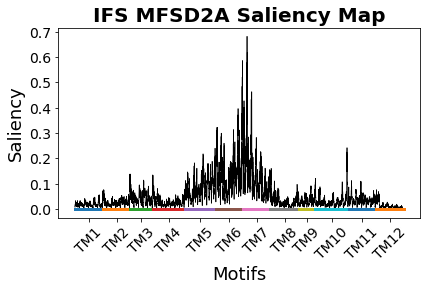

In [13]:
plt.plot(vis_sal_class3_test_mean.flatten(), "k", linewidth=0.7)
xtick_list = []

for i in range(len(motif_name)):
    motif_start_res = motif_region[i][0]
    motif_end_res = motif_region[i][1]
    motif_start_atom = np.where(prot_res_map==motif_start_res)[0][0]
    motif_end_atom = np.where(prot_res_map<=motif_end_res)[0][-1]
    plt.plot([motif_start_atom, motif_end_atom], [0, 0], linewidth=3)  # Increase the linewidth if needed
    xtick_list.append((motif_start_atom+motif_end_atom)/2)

plt.xticks(xtick_list, motif_name, rotation=45) 
plt.title('IFS MFSD2A Saliency Map', fontsize=20, fontweight='bold')
plt.xlabel('Motifs',fontsize=18)  # Label for x-axis
plt.ylabel('Saliency',fontsize=18)  # Label for y-axis
plt.tight_layout()  # Adjust the layout to fit everything
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
# plt.savefig('mfds2a_saliency_map_transformed.png', dpi=300)  # Uncomment to save the figure
plt.show()

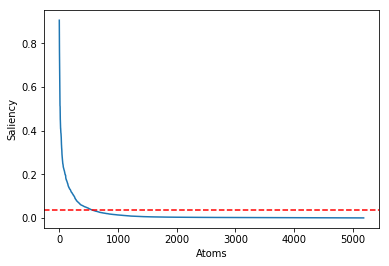

The knee point is at x (nFeat) = 608, and score of: 0.03189645945141092


In [14]:
data = sorted(vis_sal_class3_test_mean.flatten(), reverse=True)
plt.plot(data)
plt.axhline(y=0.03796322514838539, color='r', linestyle='--')
plt.xlabel('Atoms')
plt.ylabel('Saliency')
plt.show()

from kneed import KneeLocator

x = range(1, len(data) + 1)

# Find the knee point
knee_locator = KneeLocator(x, data, curve='convex', direction='decreasing', S=10)
knee_point = knee_locator.knee  # This is the x value of the knee point

print(f"The knee point is at x (nFeat) = {knee_point}, and score of: {knee_locator.knee_y}")

In [26]:
top_atoms_IFS= np.where(vis_sal_class1_test_mean.flatten()>= 0.5)[0]
top_atoms_IFS

residue_numbers = set()

# Loop through the top atoms and add their associated residue numbers to the set.
for atom_number in top_atoms_OFS:
    if 0 <= atom_number < len(prot_res_map):
        residue_number = prot_res_map[atom_number]
        residue_numbers.add(residue_number)

# Convert the set of residue numbers to a sorted list if needed.
residue_numbers_list3 = sorted(list(residue_numbers))

# Now, residue_numbers_list contains the residue numbers associated with the top 80 atoms.
print('IFS with saliency 0.5:',residue_numbers_list3)

IFS with saliency 0.5: [259, 262, 293, 294, 295, 296, 297, 299]


In [15]:
top_atoms_IFS= np.argsort(vis_sal_class3_test_mean.flatten())[-608:]
top_atoms_IFS

residue_numbers = set()

# Loop through the top atoms and add their associated residue numbers to the set.
for atom_number in top_atoms_OcS:
    if 0 <= atom_number < len(prot_res_map):
        residue_number = prot_res_map[atom_number]
        residue_numbers.add(residue_number)

# Convert the set of residue numbers to a sorted list if needed.
residue_numbers_list3 = sorted(list(residue_numbers))

# Now, residue_numbers_list contains the residue numbers associated with the top 80 atoms.
print('IFS:',residue_numbers_list3)

IFS: [189, 191, 196, 199, 200, 201, 202, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 315, 316, 317, 328]


In [20]:
common_elements = set(residue_numbers_list1) & set(residue_numbers_list2) & set(residue_numbers_list3)

# Convert the result back to a list if needed
common_elements_list = list(common_elements)

# Print the common elements
print(common_elements_list)

[259, 293, 294, 295, 262, 296]


Text(0.5,1,'MFSD2A Saliency Map transformed')

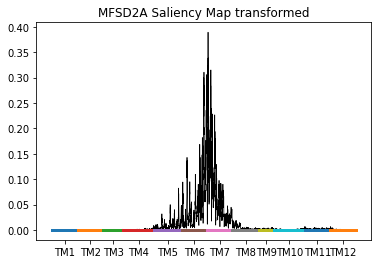

In [94]:
plt.plot(vis_sal_class1_test_mean.flatten(),"k",linewidth=0.7)
xtick_list = []
for i in range(len(motif_name)):
    motif_start_res = motif_region[i][0]
    motif_start_atom = np.where(prot_res_map>=motif_start_res)[0][0]
    motif_end_res = motif_region[i][1]
    motif_end_atom = np.where(prot_res_map<=motif_end_res)[0][-1]
    plt.plot([motif_start_atom,motif_end_atom],[0,0],linewidth=3)
    xtick_list.append((motif_start_atom+motif_end_atom)/2)
plt.xticks(xtick_list,motif_name)
plt.title('MFSD2A Saliency Map transformed')
#plt.savefig('../faDNN_chol35_sal_transformed.png', dpi=300)

In [52]:
len(vis_sal_class1_test_mean.flatten())

5184

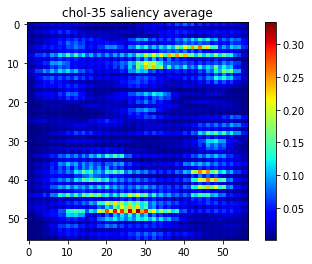

In [5]:
plt.imshow(vis_sal_class1_test_mean, cmap='jet')
plt.colorbar()
plt.title('chol-35 saliency average');
#plt.savefig('../faDNN_chol35_sal_raw.png', dpi=300)

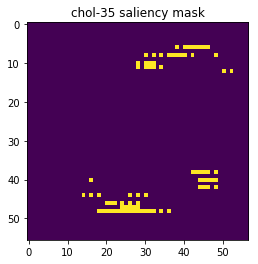

In [6]:
plt.imshow((vis_sal_class1_test_mean>np.sort(vis_sal_class1_test_mean.flatten())[-80]))
plt.title('chol-35 saliency mask')
#plt.savefig('../faDNN_chol35_sal_mask.png', dpi=300)

In [13]:
np.sum(np.isnan(vis_sal_class1_test_mean))

0

In [21]:
print(np.argsort(vis_sal_class1_test_mean.flatten())[-80:]+74)
#top 80 atoms and Hengyis protein index 74 

[2515 2778  457  810 2596 2717 2513  729 2612 2780  672 2724 2370 2841
 2846  572 2600 2829  578  732  459 2283  454  567 2598  808 2722  675
 2844 2288  735  560 2835  461  569 2720 2608 2282 2716 2399 2512 2401
 2828  676 2833 2610 2516 2831  562 2398 2777 2842  674  456  564 2285
 2718  462 2781 2837  731 2779  733 2514 2402  570  566  568 2839  458
 2286 2284  460 2400 2830 2834 2840 2832 2836 2838]


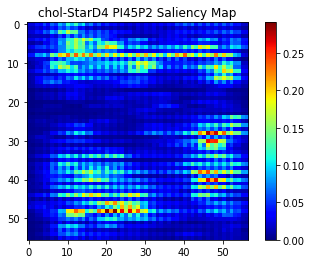

In [39]:
plt.imshow(vis_sal_class2_test_mean, cmap='jet',vmin=0)
plt.colorbar()
plt.title('chol-StarD4 PI45P2 Saliency Map');
#plt.savefig('../faDNN_chol45_sal.png', dpi=300)

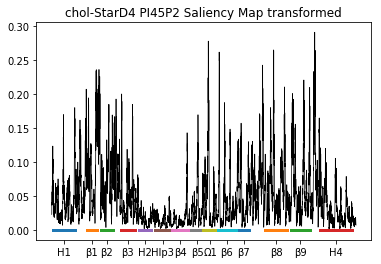

In [38]:
plt.plot(vis_sal_class2_test_mean.flatten(),"k",linewidth=0.7)
xtick_list = []
for i in range(len(motif_name)):
    motif_start_res = motif_region[i][0]
    motif_start_atom = np.where(prot_res_map>=motif_start_res)[0][0]
    motif_end_res = motif_region[i][1]
    motif_end_atom = np.where(prot_res_map<=motif_end_res)[0][-1]
    plt.plot([motif_start_atom,motif_end_atom],[0,0],linewidth=3)
    xtick_list.append((motif_start_atom+motif_end_atom)/2)
plt.xticks(xtick_list,motif_name)
plt.title('chol-StarD4 PI45P2 Saliency Map transformed')
#plt.savefig('../faDNN_chol45_sal_transformed.png', dpi=300)

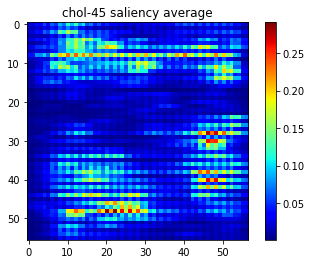

In [8]:
plt.imshow(vis_sal_class2_test_mean, cmap='jet')
plt.colorbar()
plt.title('chol-45 saliency average');
#plt.savefig('../faDNN_chol45_sal_raw.png', dpi=300)

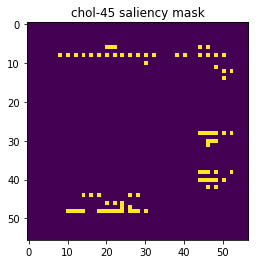

In [9]:
plt.imshow((vis_sal_class2_test_mean>np.sort(vis_sal_class2_test_mean.flatten())[-80]))
plt.title('chol-45 saliency mask')
#plt.savefig('../faDNN_chol45_sal_mask.png', dpi=300)

In [31]:
print(np.argsort(vis_sal_class2_test_mean.flatten())[-80:]+74)

[ 672  462  922  674  556  437 2399 2292  574 2833 2840  554 1715 1887
  438 2596  552 2837 2600  810 2610  576  562 2820 2720 1722 2404 2608
  749 2829 2821 2398  460  550 2285  548  808  580 2598  558 2824  538
 2823 2516  436 2777  560 2288 2716 2779 2514 2831 2401  568 2718 1714
  544  578  546 1717 2828 2284 2822  540 1720  542  570 2286 2838 1831
 1832 1830 2834 2402 2836 2400 1718 1716 2830 2832]


In [4]:
vis_sal_mean = (vis_sal_class1_test_mean+vis_sal_class2_test_mean)/2

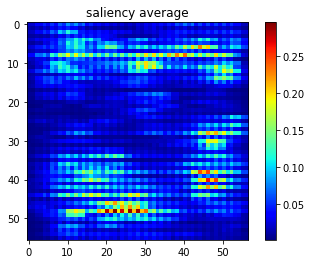

In [5]:
plt.imshow(vis_sal_mean, cmap='jet')
plt.colorbar()
plt.title('saliency average');
#plt.savefig('../faDNN_chol45_sal_raw.png', dpi=300)

Text(0.5,1,'saliency mask')

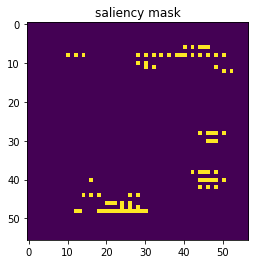

In [6]:
plt.imshow((vis_sal_mean>np.sort(vis_sal_mean.flatten())[-80]))
plt.title('saliency mask')
#plt.savefig('../faDNN_chol45_sal_mask.png', dpi=300)

In [7]:
print(np.argsort(vis_sal_mean.flatten())[-80:]+74)

[ 676 2823  576 2717  456 1714  574 2722 2404  544  558  749  461 2370
 2596  810  672 1717  580  572 2835 2282 2600  569 1831 2829 2512  564
  542 1830 2598 1832  808  540 1720 2399 2720 2608  733 2833 2822 2288
  560 2610  731  578  562  674  458 2398  462 2716 2781 2401 2516 2839
 2837 2285  566 2831 2777 1718 2828 1716 2718 2779 2514  460  568  570
 2840 2284 2286 2402 2400 2834 2830 2838 2836 2832]
